In [1]:
%pylab inline

import os
import itertools as it
from astropy.io import fits
from astropy.stats import signal_to_noise_oir_ccd as SNR_astropy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import ColorConverter

cc = ColorConverter()

from tools.stats import err, binner

from styles.paper import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def N_pix_spec(R=1800., D=3., ps=0.396):
    return 2*R*D/ps

def N_pix_imag(D=3., ps=0.396):
    return pi*(D/(2*ps))**2

def F(SNR, F_sky, N_pix, t=900., readout_noise=4., dark_noise=0., Gain=1.):
    return (SNR**2*t*Gain + sqrt(SNR**4*t*Gain**2 + 4*t**2*Gain**2*SNR**2*N_pix*(t*F_sky*Gain + t*dark_noise + readout_noise**2)))/(2*t**2*Gain**2)

def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas, obs_color, lib_color):
    n, our_edge = histogram(obs_color, 15, range=(1.0,3.0))
    n, lur_edge = histogram(lib_color, 15, range=(1.0,3.0))
    
    discrepancy = zeros(model_jpas.size)
    for i in xrange(our_edge.size-1):
        obin = (obs_color>=our_edge[i])&(obs_color<our_edge[i+1])
        lbin = (lib_color>=lur_edge[i])&(lib_color<lur_edge[i+1])
        
        discrepancy[obin] = (model_jpas[obin]-model_spec[obin]) - (median(residual_jpas[lbin])-median(residual_spec[lbin]))
    
    return discrepancy

In [3]:
ssag_lb = r"\bf SSAG"
sdss_lb = r"\bf BB"
jpas_lb = r"\bf NB"
spec_lb = r"\bf HR"

sfgs_lb = r"\bf SFGs"
pags_lb = r"\bf PaGs"
algs_lb = r"\bf All Galaxies"

#download and load spectroscopic throughput from SDSS
#load tables
snr = genfromtxt("data/sample-obs/snr_spec.txt", dtype=None, names=True)
cat = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)

_in_snr = array([i for i in xrange(cat.size) if cat["input_file"][i] in snr["input_file"]], dtype=np.int)

cat = cat[_in_snr]

snr[cat["u_mag"]>0]
cat[cat["u_mag"]>0]

#load outputs from S/N tests
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

ocolor = loadtxt("data/sample-sim/ur_color.txt")
jpas_obs = zeros(ocolor.size, dtype=zip(fields, ["<f8"]*6))
spec_obs = copy(jpas_obs)
for m in fields:
    spec_obs[m] = loadtxt("data/sample-sim/SPEC_{}.txt".format(m))
    jpas_obs[m] = loadtxt("data/sample-sim/JPAS_{}.txt".format(m))

#original TTA
sdss_tta = genfromtxt("../inputs/tta_cb13/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#low-S/N test (S/N=20 for all spectral resolutions)
sdss_lsn = genfromtxt("../inputs/proof_sn20/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_lsn = genfromtxt("../inputs/proof_sn20/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_lsn = genfromtxt("../inputs/proof_sn20/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#high-S/N test (S/N=45 for all spectral resolutions)
sdss_hsn = genfromtxt("../inputs/proof_sn45/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_hsn = genfromtxt("../inputs/proof_sn45/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_hsn = genfromtxt("../inputs/proof_sn45/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

sdss_lsn["M_mod"] = log10(sdss_lsn["M_mod"])
jpas_lsn["M_mod"] = log10(jpas_lsn["M_mod"])
spec_lsn["M_mod"] = log10(spec_lsn["M_mod"])

sdss_hsn["M_mod"] = log10(sdss_hsn["M_mod"])
jpas_hsn["M_mod"] = log10(jpas_hsn["M_mod"])
spec_hsn["M_mod"] = log10(spec_hsn["M_mod"])

#compute residuals and discrepancies
sdss_res_tta = dict(
    M=err(ssag_tta["M_lib"], sdss_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_tta["Av_mod"], False)
)
jpas_res_tta = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res_tta = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict([(k, unbiased_disc(spec_tta[k+"_mod"], jpas_tta[k+"_mod"], spec_res_tta[k], jpas_res_tta[k], lcolor, lcolor)) for k in kws])

sdss_res_lsn = dict(
    M=err(ssag_tta["M_lib"], sdss_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_lsn["Av_mod"], False)
)
jpas_res_lsn = dict(
    M=err(ssag_tta["M_lib"], jpas_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_lsn["Av_mod"], False)
)
spec_res_lsn = dict(
    M=err(ssag_tta["M_lib"], spec_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_lsn["Av_mod"], False)
)
lsn_con = dict([(k, unbiased_disc(spec_lsn[k+"_mod"], jpas_lsn[k+"_mod"], spec_res_lsn[k], jpas_res_lsn[k], lcolor, lcolor)) for k in kws])

sdss_res_hsn = dict(
    M=err(ssag_tta["M_lib"], sdss_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_hsn["Av_mod"], False)
)
jpas_res_hsn = dict(
    M=err(ssag_tta["M_lib"], jpas_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_hsn["Av_mod"], False)
)
spec_res_hsn = dict(
    M=err(ssag_tta["M_lib"], spec_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_hsn["Av_mod"], False)
)
hsn_con = dict([(k, unbiased_disc(spec_hsn[k+"_mod"], jpas_hsn[k+"_mod"], spec_res_hsn[k], jpas_res_hsn[k], lcolor, lcolor)) for k in kws])

obs_con_tta = dict([(k, unbiased_disc(spec_obs[k+"_mod"], jpas_obs[k+"_mod"], spec_res_tta[k], jpas_res_tta[k], ocolor, lcolor)) for k in kws])
obs_con_lsn = dict([(k, unbiased_disc(spec_obs[k+"_mod"], jpas_obs[k+"_mod"], spec_res_lsn[k], jpas_res_lsn[k], ocolor, lcolor)) for k in kws])
obs_con_hsn = dict([(k, unbiased_disc(spec_obs[k+"_mod"], jpas_obs[k+"_mod"], spec_res_hsn[k], jpas_res_hsn[k], ocolor, lcolor)) for k in kws])

In [4]:
def residual_table(residuals, masks, residual_labels, mask_labels, keywords):

    for i in xrange(len(keywords)):
        bias_a, pres_a = [], []
        bias_b, pres_b = [], []
        bias_c, pres_c = [], []
        for mask in masks:
            bias_a.append(median(residuals[0][keywords[i]][mask]))
            pres_a.append(diff(percentile(residuals[0][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_b.append(median(residuals[1][keywords[i]][mask]))
            pres_b.append(diff(percentile(residuals[1][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_c.append(median(residuals[2][keywords[i]][mask]))
            pres_c.append(diff(percentile(residuals[2][keywords[i]][mask], [16,84]))[0]*0.5)

        for j in xrange(len(masks)):
            if j==0:
                print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (residual_labels[i], mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
            else:
                print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
        print r"\hline"
    
    return None

def delta_distributions(residuals, res_ids, res_label=Delta, prop=(lcolor,lcolor), prop_label=r"\bf $u-r$", limits=((-0.7,+0.7),(1.3,3.0)), nbins=15, stats=(median,lambda x: abs(percentile(x,[16,84])-median(x))), colors=((samples["dark"],samples["light"]),samples["cold"])):
    xlm, ylm = limits
    
    fig, axs = subplots(1, len(kws), figsize=(7, 3.3), sharex=True, sharey=True)

    axr = []
    for ax in axs:
        divider = make_axes_locatable(ax)
        axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))

        plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
        axr[-1].set_ylim(0, 1.2)

    axs = row_stack((axr, axs))

    axs[0,0].set_xlim(xlm)
    axs[0,0].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))
    axs[0,0].set_ylabel(r"\bf $N/N_\text{max}$")
    axs[1,0].set_ylabel(prop_label)

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        if i==0:
            N_a = histogram(residuals[0][kws[j]], 20, range=xlm)[0].max().repeat(residuals[0][kws[j]].size)
            N_b = histogram(residuals[1][kws[j]], 20, range=xlm)[0].max().repeat(residuals[1][kws[j]].size)

            axs[i, j].hist(residuals[0][kws[j]], 20, range=xlm, weights=1.0/N_a, histtype="stepfilled", color=colors[0][1], lw=0, label=res_ids[0])
            axs[i, j].hist(residuals[1][kws[j]], 20, range=xlm, weights=1.0/N_b, histtype="step", color=colors[1], label=res_ids[1])

            med_a = stats[0](residuals[0][kws[j]])
            med_b = stats[0](residuals[1][kws[j]])
            med_a_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_a, 0.0)))+array([0,0.2])
            med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
            axs[i, j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":colors[0][0],"ec":"none"})
            axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":colors[1],"ec":"none"})
        else:
            xa, ya, ea = binner(prop[0], residuals[0][kws[j]], nbins, ylm, stats)
            xb, yb, eb = binner(prop[1], residuals[1][kws[j]], nbins, ylm, stats)

            axs[i, j].plot(gaussian_filter(ya,1.5), xa, "-", color=colors[0][0], lw=1.5)
            axs[i, j].fill_betweenx(xa, gaussian_filter(ya-ea[0],1.5), gaussian_filter(ya+ea[1],1.5), facecolor=colors[0][1], lw=0)

            axs[i, j].plot(gaussian_filter(yb,1.5), xb, "-", color=colors[1], lw=1.5)
            axs[i, j].plot(gaussian_filter(yb-eb[0],1.5), xb, "--", color=colors[1], lw=1.0)
            axs[i, j].plot(gaussian_filter(yb+eb[1],1.5), xb, "--", color=colors[1], lw=1.0)

            axs[i, j].axvline(ls=":", color=samples["dark"], lw=0.5)
            axs[i, j].axhline(2.22, ls=":", color=samples["dark"], lw=0.5)

            axs[i, j].set_xlabel(res_label[kws[j]])

    axs[1, 0].set_ylim(xa[0], xa[-1])
    axs[0, 0].legend(loc=1, handlelength=0.3, handletextpad=0.3)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1)
    
    return fig

def residuals_vs_prop(residuals, res_ids, res_leg, keywords, res_lbs, colors, linestyles, limits=((-0.7,+0.7),(1.3,3.0)), nbins=15):
    xlm, ylm = limits

    fig, axs = subplots(len(residuals), len(keywords), figsize=(7,4), sharex=True, sharey=True)

    axs[0,0].set_xlim(xlm)
    axs[0,0].xaxis.set_major_locator(MaxNLocator(nbins=4, prune="both"))

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        axs[i,j].axvline(ls="-.", color="w", lw=0.5)
        axs[i,j].axhline(2.22, ls="-.", color="w", lw=0.5)
        for k in xrange(len(residuals[i])):
            x, y, e = binner(lcolor, residuals[i][k][keywords[j]], nbins, ylm, (median,lambda x: abs(percentile(x,[16,84])-median(x))))

            axs[i,j].plot(gaussian_filter(y,1.5), x, linestyles[k], color=colors[0], lw=1, label=res_leg[k])
            axs[i,j].fill_betweenx(x, gaussian_filter(y-e[0],1.5), gaussian_filter(y+e[1],1.5), facecolor=colors[1][k], lw=0)

        if axs[i,j].is_first_col():
            axs[i,j].set_ylabel(r"\bf $u-r$")
            axs[i,j].text(0.05, 0.95, res_ids[i], fontsize="x-small", ha="left", va="top", transform=axs[i,j].transAxes)
        if axs[i,j].is_last_row():
            axs[i,j].set_xlabel(res_lbs[keywords[j]])

    axs[1,0].set_ylim(x[0], x[-1])
    axs[-1,0].legend(loc=4, handlelength=1.5, handletextpad=0.5)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.07, hspace=0.07)
    
    return fig

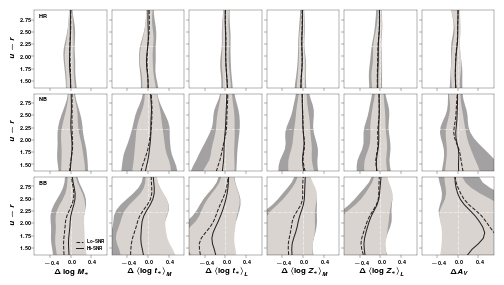

In [5]:
fig = residuals_vs_prop(((spec_res_lsn,spec_res_hsn),(jpas_res_lsn,jpas_res_hsn),(sdss_res_lsn,sdss_res_hsn)), (spec_lb,jpas_lb,sdss_lb), (r"\bf Lo-SNR", r"\bf Hi-SNR"), keywords=kws, res_lbs=Delta, colors=(samples["dark"],(samples["medium"],samples["light"])), linestyles=("--","-"), limits=((-0.7,+0.7),(1.3,3.0)))
fig.savefig(os.path.expandvars("$HOME/Documents/Publications/mejia+2016/residuals_vs_snr"))

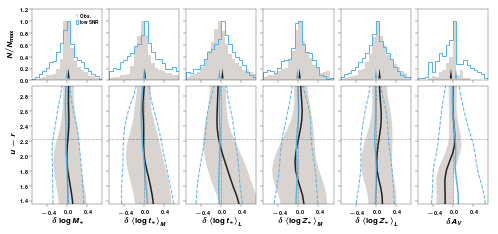

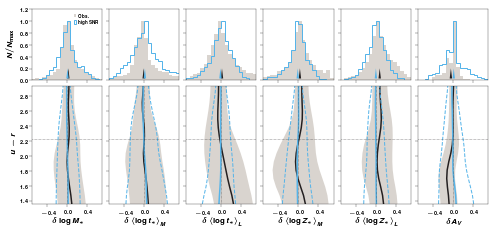

In [6]:
fig = delta_distributions((obs_con_lsn,lsn_con), (r"\bf Obs.",r"\bf low SNR"), delta, prop=(ocolor,lcolor), stats=(mean, lambda x: std(x, ddof=1)))
fig = delta_distributions((obs_con_hsn,hsn_con), (r"\bf Obs.",r"\bf high SNR"), delta, prop=(ocolor,lcolor), stats=(mean, lambda x: std(x, ddof=1)))

[ 19.0521  18.0314  17.0769]
[ 0.0116  0.007   0.0037]
[5, 3, 3]
10.0 9.99994310588
16.22 16.2195984119
32.09 32.0869327695


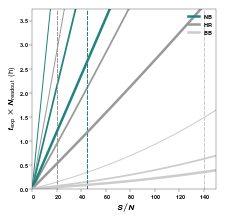

In [7]:
#select one galaxy in r=16,18,20 bins
bins = percentile(cat["r_mag"], [5,50,95])

true_snr = [snr["snr_wall"][argmin(abs(mag-cat["r_mag"]))] for mag in bins]
isort = argsort(true_snr)
true_snr = np.sort(true_snr)

spec_name = array([cat["input_file"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]
true_mag = array([cat["r_mag"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]
true_err = array([cat["r_err"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]

print true_mag
print true_err

#get relevant data from FITS: expTime, readout noise, etc.
fdir = os.path.expandvars("$phd/inputs/real_deal/fits/")
spec_fits = [fits.open(fdir+fit) for fit in spec_name]
spec_expt = [f[0].header["EXPTIME"] for f in spec_fits]
spec_nr = [int(expt/60./15.) for expt in spec_expt]

print spec_nr

F_spec = []
for i,f in enumerate(spec_fits):
    #read original (observed SED)
    wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
    wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
    flux = f[0].data[0]*1e-17
    wlen = wlen[flux>0]
    flux = flux[flux>0]
    #compute spectroscopic F = mean(F_lambda*h_s)
    F_spec.append(F(true_snr[i], F_sky=0.0, N_pix=N_pix_spec(), t=spec_expt[i], readout_noise=sqrt(spec_nr[i])*4.0))
    #using the expTime, reproduce the reported SNR values
    print true_snr[i], SNR_astropy(spec_expt[i], F_spec[i], 0.0, 0.0, sqrt(spec_nr[i])*4.0, N_pix_spec())

#compute photometric F = sum(F_i*h_i)/nf ~ F_spec for the J-PAS filter set
F_pho = map(lambda x: x/0.25*0.5, F_spec)

tt = linspace(5.0, 60*4*56., 1000)
lws = [1, 1.75, 2.5]
for i in xrange(len(spec_name)):
    #if i not in [0,2]: continue
    #compute the J-PAS SNR using the instrument values from Benitez et al. 2014
    SNR_jpas = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, sqrt(56*4)*4., 56*N_pix_imag(D=3., ps=0.227))
    #also plot SDSS photometry for comparison
    SNR_ugriz = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, sqrt(5)*4., 5*N_pix_imag(D=3., ps=0.396))
    #plot the SNR vs. t for the SDSS spectra and for the J-PAS
    SNR_sdss = lambda t: SNR_astropy(t, F_spec[i], 0.0, 0.0, sqrt(spec_nr[i])*4., N_pix_spec(R=1800., D=3., ps=0.396))

    axvline(45., ls="--", color="#218380", lw=1)
    axvline(20., ls="--", color="0.6", lw=1)
    axvline(140, ls="--", color="0.8", lw=1)

    if i==2:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i], label=jpas_lb)
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i], label=spec_lb)
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i], label=sdss_lb)
    else:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i])
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i])
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i])

legend(loc=1, fontsize="x-small")
xlim(0,150)
ylim(0,tt.max()/3600)

xlabel(r"$S/N$")
ylabel(r"$t_\text{exp}\times N_\text{readout}$ (h)")

In [8]:
time = linspace(5.,60*56*4*10, 10000000)

print time[argmin(abs(SNR_astropy(time, F_pho[0], 0.0, 0.0, sqrt(56*4)*4., 56*N_pix_imag(D=3.,ps=0.227))-45))]/56/4
print time[argmin(abs(SNR_astropy(time, F_pho[1], 0.0, 0.0, sqrt(56*4)*4., 56*N_pix_imag(D=3.,ps=0.227))-45))]/56/4
print time[argmin(abs(SNR_astropy(time, F_pho[2], 0.0, 0.0, sqrt(56*4)*4., 56*N_pix_imag(D=3.,ps=0.227))-45))]/56/4
print
print time[argmin(abs(SNR_astropy(time, F_pho[0], 0.0, 0.0, sqrt(5)*4., 5*N_pix_imag(D=3., ps=0.396))-140))]/5/300
print time[argmin(abs(SNR_astropy(time, F_pho[1], 0.0, 0.0, sqrt(5)*4., 5*N_pix_imag(D=3., ps=0.396))-140))]/5/300
print time[argmin(abs(SNR_astropy(time, F_pho[2], 0.0, 0.0, sqrt(5)*4., 5*N_pix_imag(D=3., ps=0.396))-140))]/5/300
print
print time[argmin(abs(SNR_astropy(time, F_spec[0], 0.0, 0.0, sqrt(spec_nr[0])*4., N_pix_spec(R=1800., D=3., ps=0.396))-20))]
print time[argmin(abs(SNR_astropy(time, F_spec[1], 0.0, 0.0, sqrt(spec_nr[1])*4., N_pix_spec(R=1800., D=3., ps=0.396))-20))]
print time[argmin(abs(SNR_astropy(time, F_spec[2], 0.0, 0.0, sqrt(spec_nr[2])*4., N_pix_spec(R=1800., D=3., ps=0.396))-20))]
print
print time[argmin(abs(SNR_astropy(time, F_pho[2], 0.0, 0.0, sqrt(56*4)*4., 56*N_pix_imag(D=3.,ps=0.227))-20))]
print 4240/1861.

182.141304129
76.4956039821
42.6941181444

3.55575192524
1.49334396833
0.833473412014

10234.637722
3336.0476056
1861.93590069

4240.32445353
2.27834497582


In [9]:
print "TTA ----------------------------------------------------------------------------------------------------"
residual_table([spec_res_tta,jpas_res_tta,sdss_res_tta], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)
print "S/N = 20 -----------------------------------------------------------------------------------------------"
residual_table([spec_res_lsn,jpas_res_lsn,sdss_res_lsn], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)
print "S/N = 45 ----------------------------------------------------------------------------------------------"
residual_table([spec_res_hsn,jpas_res_hsn,sdss_res_hsn], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)

TTA ----------------------------------------------------------------------------------------------------
\multirow{3}{*}{\dlogm}   &      SFGs &     0.001 &     0.101 & &     0.011 &     0.215 & &     0.091 &     0.264\\
                          &      PaGs &     0.005 &     0.071 & &     0.019 &     0.125 & &     0.110 &     0.140\\
                          & All Gals. &     0.004 &     0.092 & &     0.015 &     0.178 & &     0.102 &     0.216\\
\hline
\multirow{3}{*}{\dmwla}   &      SFGs &     0.003 &     0.159 & &     0.002 &     0.339 & &     0.101 &     0.454\\
                          &      PaGs &     0.028 &     0.110 & &     0.065 &     0.193 & &     0.143 &     0.192\\
                          & All Gals. &     0.012 &     0.139 & &     0.033 &     0.281 & &     0.124 &     0.370\\
\hline
\multirow{3}{*}{\dlwla}   &      SFGs &     0.018 &     0.098 & &    -0.023 &     0.214 & &     0.047 &     0.289\\
                          &      PaGs &     0.009 &     0.086 & &    